In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from google.colab import auth
auth.authenticate_user()

In [112]:
data_path = 'gs://dataprep-staging-a351fd7d-4575-4a19-86f3-a0e85c39fc88/nataliia.shcheglovaa@gmail.com/jobrun/Capstone_3_data/trips_no_geom.csv'
data = pd.read_csv(data_path, storage_options={'token': 'cloud'}, encoding='latin-1', engine='c')

In [4]:
data.head()

,request_date,request_hour,hvfhs_license_num,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,...,cloudcover,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request
0,2021-01-01,0,HV0003,3,68,6.790931,0.080882,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
1,2021-01-01,0,HV0003,4,100,4.221833,2.722500,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
2,2021-01-01,0,HV0003,5,14,10.142857,0.000000,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
3,2021-01-01,0,HV0003,6,18,7.538889,0.152778,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
4,2021-01-01,0,HV0003,7,195,3.579316,0.394872,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0


In [113]:
data['request_datetime'] = pd.to_datetime(data['request_date'].astype(str)+' '+ data['request_hour'].astype(str)+':00:00')
data.head()

,request_date,request_hour,hvfhs_license_num,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,...,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request,request_datetime
0,2021-01-01,0,HV0003,3,68,6.790931,0.080882,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
1,2021-01-01,0,HV0003,4,100,4.221833,2.722500,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
2,2021-01-01,0,HV0003,5,14,10.142857,0.000000,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
3,2021-01-01,0,HV0003,6,18,7.538889,0.152778,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01
4,2021-01-01,0,HV0003,7,195,3.579316,0.394872,2.5,-3.0,67.8,...,1,0,1,1,4,0,1,0,0,2021-01-01


# SARIMA model with weather features as exogenous variables

My data is time series with three levels of seasonality: hourly (rush hours vs night hours), daily (weekends vs weekdays) and monthly (last 3 months of the year being more busy). Additionally, weather factors and zone also play a role. I'll try to create a SARIMA model that incorporates all of these.

In [114]:
# Selecting sample of data for one zone only
data_sample = data.loc[data['PULocationID']==231,['request_datetime','request_date','request_hour','passenger_count','temp','dew','humidity','precip','cloudcover','rain','snow']]
data_sample.head()

,request_datetime,request_date,request_hour,passenger_count,temp,dew,humidity,precip,cloudcover,rain,snow
221,2021-01-01 00:00:00,2021-01-01,0,187,2.5,-3.0,67.8,15.33,50.6,1,0
474,2021-01-01 01:00:00,2021-01-01,1,201,2.5,-3.0,67.8,15.33,50.6,1,0
723,2021-01-01 02:00:00,2021-01-01,2,141,2.5,-3.0,67.8,15.33,50.6,1,0
969,2021-01-01 03:00:00,2021-01-01,3,70,2.5,-3.0,67.8,15.33,50.6,1,0
1219,2021-01-01 04:00:00,2021-01-01,4,48,2.5,-3.0,67.8,15.33,50.6,1,0


In [115]:
data_sample['request_datetime'] = pd.to_datetime(data_sample['request_datetime'])
data_sample.set_index('request_datetime', inplace=True)
data_sample = data_sample[~data_sample.index.duplicated(keep='first')]  # Removing duplicate indices
data_sample = data_sample.resample('h').ffill()

In [116]:
data_sar = data_sample[data_sample['request_date']<'2021-12-21']

In [126]:
# Checking if data is stationary
y_train_sar = data_sar['passenger_count']
y_train_sar = pd.Series(y_train_sar, index=data_sar.index)
result = sm.tsa.stattools.adfuller(y_train_sar)
print('Dickey-Fuller: p={0:.5f}'.format(result[1]))

Dickey-Fuller: p=0.00000


Null hypothesis for Dickey_Fuller test is that data is non-stationary. Given the p-value of 0 we rejact the null hypothesis.
The test suggests that the data is stationary.

<Figure size 1000x500 with 0 Axes>

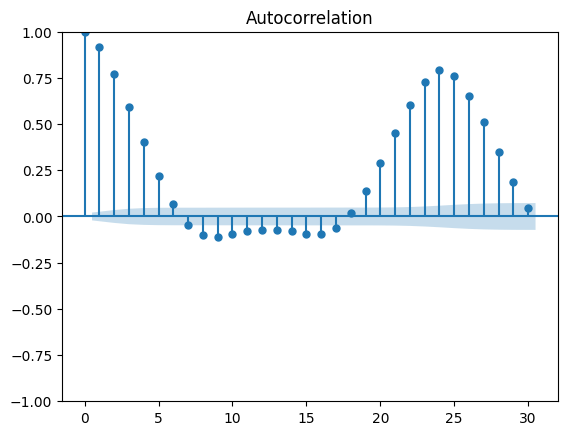

<Figure size 1000x500 with 0 Axes>

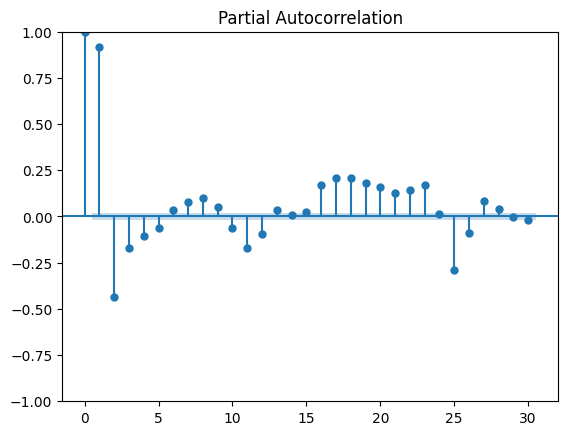

In [119]:
# Checking for autocorrelation and seasonality
plt.figure(figsize=(10, 5))
plot_acf(y_train_sar, lags=30)  # ACF for first 30 lags
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(y_train_sar, lags=30)  # PACF for first 30 lags
plt.show()

ACF plot suggests that my time series have strong autocorrelation at shorter lags, a daily pattern (there's a spike at lag 24), and possible trend-like behavior (there's a slow decay of ACF).

PACF:
After lag 1, the partial autocorrelation drops significantly, which suggests
that current value is greatly influenced by the number of trip requests in the previous hour.

In [128]:
data_diff = y_train_sar.diff(24).dropna()
result = sm.tsa.stattools.adfuller(data_diff)
print('p-value after seasonal differencing:', result[1])

p-value after seasonal differencing: 2.154700045913003e-25


P-value for Dickey-Fuller test is still very low evan after seasonal differencing - another confirmation that data is stationary.

In [143]:
# Creating Fourier terms for daily, weekly, and yearly seasonality
fourier = CalendarFourier(freq='YE', order=3)  # Yearly seasonality
dp = DeterministicProcess(
    index=data_sar.index,
    constant=True,               # intercept term
    order=1,                     # trend (linear)
    seasonal=True,               # weekly seasonality
    additional_terms=[fourier],  # yearly seasonality via Fourier terms
    drop=True,                   # drop missing dates
)

In [144]:
X_time = dp.in_sample()
X_fore_time = dp.out_of_sample(steps=24)  # Forecasting 24 hours into the future

In [145]:
# Including weather features as exogenous variables
exog_features = pd.concat([X_time, data_sar[['temp','dew','humidity','cloudcover','rain','snow']]], axis=1)
exog_features = exog_features.replace([np.inf, -np.inf], np.nan)  # Replacing inf with NaN
exog_features = exog_features.ffill() # Filling in null values


In [146]:
# Fit SARIMAX model with exogenous regressors (Fourier terms and weather)
sarimax_model = SARIMAX(
    data_sar['passenger_count'],
    order=(1, 1, 1),                # Need to adjust these parameters based on AIC/BIC tuning
    seasonal_order=(1, 1, 1, 24),   # To capture daily seasonality
    exog=exog_features)

In [149]:
sarimax_fit = sarimax_model.fit(disp=False)

In [150]:
# In my case I have actual weather data available for the next day. In reality we can use weather forecast here
X_fore_weather = data.loc[(data['PULocationID']==231)&(data['request_date']=='2021-12-21'),['temp','dew','humidity','cloudcover','rain','snow']].iloc[0]
X_fore_weather = pd.DataFrame(X_fore_weather).T
X_fore_weather = pd.concat([X_fore_weather] * 24, ignore_index=True) # Repeat for 24 hours
X_fore_weather.index = pd.date_range(data_sar.index[-1] + pd.DateOffset(hours=1), periods=24, freq='h') # Set index starting from the next hour

In [151]:
# Combining time-related exogenous features and forecasted weather data
X_fore = pd.concat([X_fore_time, X_fore_weather], axis=1)

In [152]:
# Making predictions
forecast = sarimax_fit.get_forecast(steps=24, exog=X_fore)
forecast_ci = forecast.conf_int()

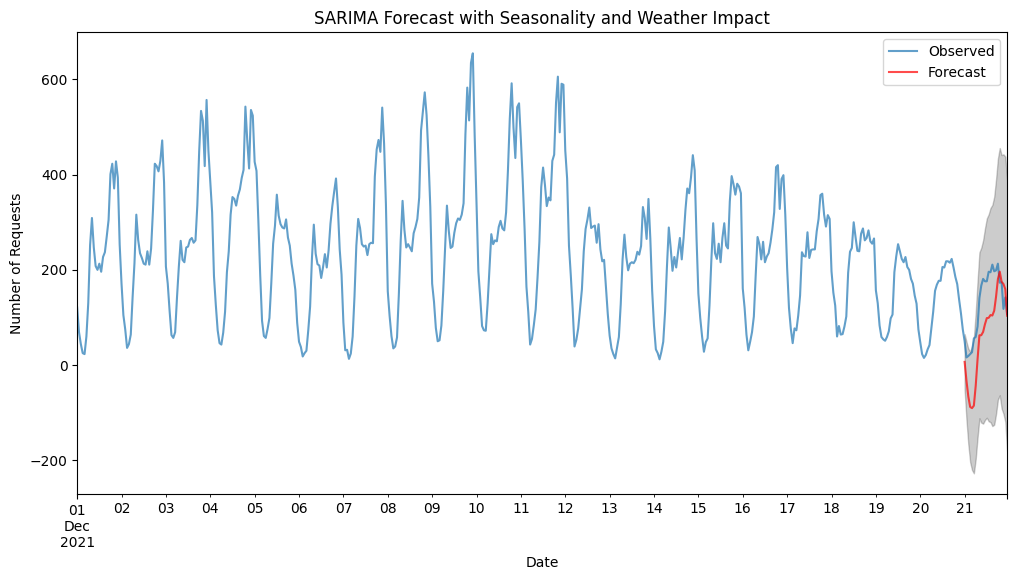

In [153]:
# Plotting the observed data and forecast
data_sar2 = data_sample[data_sample['request_date']<='2021-12-21']
plt.figure(figsize=(12, 6))
data_sar2.loc[data_sar2['request_date']>='2021-12-01','passenger_count'].plot(label='Observed', alpha=0.7)
forecast.predicted_mean.plot(label='Forecast', color='red', alpha=0.7)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.title('SARIMA Forecast with Seasonality and Weather Impact')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [176]:
y_test_sar = data_sar2.loc[data_sar2['request_date']=='2021-12-01','passenger_count']
mae_sarimax = mean_absolute_error(y_test_sar, forecast.predicted_mean)
mse_sarimax = mean_squared_error(y_test_sar, forecast.predicted_mean)
rmse_sarimax = mse_sarimax ** 0.5

print(f'SARIMAX MAE: {mae_sarimax}, RMSE: {rmse_sarimax}')

SARIMAX MAE: 160.9508331347121, RMSE: 168.8494021049228


In [110]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    passenger_count   No. Observations:                 8496
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -40777.911
Date:                            Sun, 13 Oct 2024   AIC                          81639.822
Time:                                    06:21:28   BIC                          81935.686
Sample:                                01-01-2021   HQIC                         81740.802
                                     - 12-20-2021                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.972e-05   7197.495   4.13e-09      1.000   -1.41e+04    1.41e+04
trend                  0.0004   1.74e+04   2.46e-08      1.000   -3.42e+04    3.42e+04
s(2,24)               -0.0003   3.33e+04   -9.6e-09      1.000   -6.53e+04    6.53e+04
s(3,24)            -5.007e-05   1.88e+04  -2.66e-09      1.000   -3.69e+04    3.69e+04
s(4,24)                0.0002   2.76e+04   5.94e-09      1.000   -5.41e+04    5.41e+04
s(5,24)            -7.413e-05   3.26e+04  -2.27e-09      1.000   -6.39e+04    6.39e+04
s(6,24)             3.764e-06   2.89e+04    1.3e-10      1.000   -5.66e+04    5.66e+04
s(7,24)              2.31e-06   4.88e+04   4.74e-11      1.000   -9.56e+04    9.56e+04
s(8,24)            -9.334e-05   3.66e+04  -2.55e-09      1.000   -7.17e+04    7.17e+04
s(9,24)                0.0003   3.94e+04   7.46e-09      1.000   -7.73e+04    7.73e+04
s(10,24)           -3.203e-05   4.34e+04  -7.38e-10      1.000    -8.5e+04     8.5e+04
s(11,24)           -3.187e-05   3.55e+04  -8.98e-10      1.000   -6.96e+04    6.96e+04
s(12,24)            -4.87e-05   4.28e+04  -1.14e-09      1.000    -8.4e+04     8.4e+04
s(13,24)            8.257e-05   3.72e+04   2.22e-09      1.000   -7.29e+04    7.29e+04
s(14,24)           -2.988e-05   3.87e+04  -7.73e-10      1.000   -7.58e+04    7.58e+04
s(15,24)            7.522e-06   4.61e+04   1.63e-10      1.000   -9.04e+04    9.04e+04
s(16,24)           -2.521e-05   3.59e+04  -7.03e-10      1.000   -7.03e+04    7.03e+04
s(17,24)              -0.0001   4.18e+04  -2.94e-09      1.000   -8.19e+04    8.19e+04
s(18,24)            2.102e-05   3.75e+04    5.6e-10      1.000   -7.36e+04    7.36e+04
s(19,24)            9.456e-05   4.15e+04   2.28e-09      1.000   -8.13e+04    8.13e+04
s(20,24)               0.0001   3.72e+04   3.64e-09      1.000   -7.28e+04    7.28e+04
s(21,24)              -0.0001   3.31e+04  -3.36e-09      1.000   -6.48e+04    6.48e+04
s(22,24)            5.365e-06   4.22e+04   1.27e-10      1.000   -8.28e+04    8.28e+04
s(23,24)            6.157e-05   1.82e+04   3.39e-09      1.000   -3.56e+04    3.56e+04
s(24,24)           -4.354e-05   4.24e+04  -1.03e-09      1.000   -8.32e+04    8.32e+04
sin(1,freq=YE-DEC)    68.2870   1473.727      0.046      0.963   -2820.166    2956.739
cos(1,freq=YE-DEC) -3874.5408   2220.401     -1.745      0.081   -8226.446     477.365
sin(2,freq=YE-DEC)    11.3171    535.877      0.021      0.983   -1038.983    1061.617
cos(2,freq=YE-DEC)  -978.9862    589.436     -1.661      0.097   -2134.259     176.286
sin(3,freq=YE-DEC)    24.4834    316.076      0.077      0.938    -595.014     643.981
cos(3,freq=YE-DEC)  -436.2528    350.551     -1.244      0.213   -1123.320     250.815
temp                  -1.5121      2.341     -0.646      0.518      -6.101       3.076
dew                    2.6036      2.592      1.004      0.315      -2.477       7.684
h

Seems like quite a bad model.

# Linear regression

In [158]:
# Preparing data for linear regression
data_lr = data.loc[data['PULocationID']==231,['request_datetime','request_month','request_day','request_hour','request_day_of_week','morning_time_request','evening_time_request','day_time_request','night_time_request','passenger_count','temp','dew','humidity','precip','cloudcover','rain','snow']]
data_lr['request_datetime'] = pd.to_datetime(data_lr['request_datetime'])
data_lr.set_index('request_datetime', inplace=True)
data_lr = data_lr[~data_lr.index.duplicated(keep='first')]
data_lr.head()

,request_month,request_day,request_hour,request_day_of_week,morning_time_request,evening_time_request,day_time_request,night_time_request,passenger_count,temp,dew,humidity,precip,cloudcover,rain,snow
request_datetime,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1,1,0,4,0,0,0,1,187,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 01:00:00,1,1,1,4,0,0,0,1,201,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 02:00:00,1,1,2,4,0,0,0,1,141,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 03:00:00,1,1,3,4,0,0,0,1,70,2.5,-3.0,67.8,15.33,50.6,1,0
2021-01-01 04:00:00,1,1,4,4,0,0,0,1,48,2.5,-3.0,67.8,15.33,50.6,1,0


In [159]:
# Since my data has autocorrelation, I'm creating lagged variables as additional features - number of uber requests in the previous hour
# and number of requests at this time previous day
data_lr['lag_1'] = data_lr['passenger_count'].shift(1)
data_lr['lag_24'] = data_lr['passenger_count'].shift(24)

In [160]:
data_lr = data_lr.dropna()

In [161]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8735 entries, 2021-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   request_month         8735 non-null   int64  
 1   request_day           8735 non-null   int64  
 2   request_hour          8735 non-null   int64  
 3   request_day_of_week   8735 non-null   int64  
 4   morning_time_request  8735 non-null   int64  
 5   evening_time_request  8735 non-null   int64  
 6   day_time_request      8735 non-null   int64  
 7   night_time_request    8735 non-null   int64  
 8   passenger_count       8735 non-null   int64  
 9   temp                  8735 non-null   float64
 10  dew                   8735 non-null   float64
 11  humidity              8735 non-null   float64
 12  precip                8735 non-null   float64
 13  cloudcover            8735 non-null   float64
 14  rain                  8735 non-null 

In [162]:
X = data_lr.drop('passenger_count', axis=1)
y = data_lr['passenger_count']

In [163]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [165]:
y_pred = model_lr.predict(X_test)

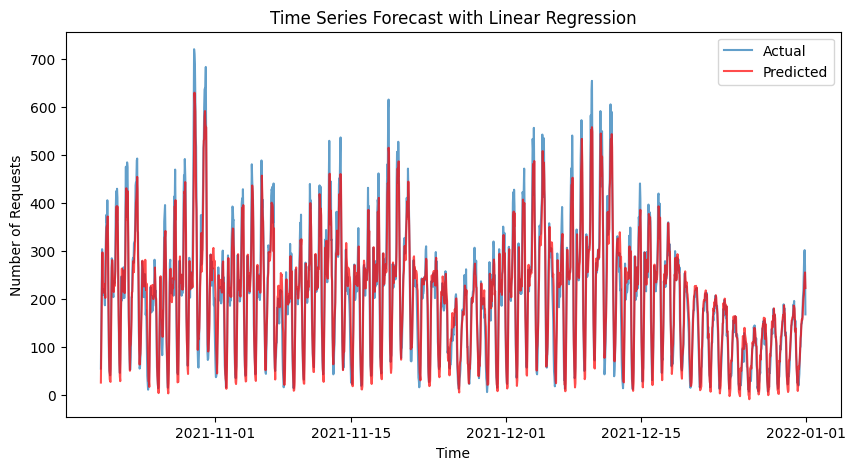

In [166]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with Linear Regression')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [167]:
# Checking model's performance
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = mse_linear ** 0.5
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression MAE: {mae_linear}, RMSE: {rmse_linear}, R2: {r2}')

Linear Regression MAE: 31.004864319850395, RMSE: 41.5244262257548, R2: 0.89642746986185


MAE & RMSE are much smaller than in SARIMAX model. R-squared of 0.89 indicates a good performance.

In [168]:
intercept = model_lr.intercept_
coefficients = model_lr.coef_

coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

print(f"Intercept: {intercept}")
print(coeff_df)

Intercept: 163.86241002670326
                 Feature   Coefficient
0          request_month  9.794072e-01
1            request_day -9.438336e-02
2           request_hour -1.271199e+01
3    request_day_of_week -3.095703e+00
4   morning_time_request -2.904866e+14
5   evening_time_request -2.904866e+14
6       day_time_request -2.904866e+14
7     night_time_request -2.904423e+14
8                   temp -1.189602e+00
9                    dew  1.501011e+00
10              humidity -1.128448e+00
11                precip -5.247867e-03
12            cloudcover -1.574600e-01
13                  rain  2.576751e-02
14                  snow -9.244808e-01
15                 lag_1  7.351893e+01
16                lag_24  2.148880e+01


### Linear regression with only one lagged feature
In practice it may be hard to feed model with number of requests in the previous hour. I'll create linear model with only one lagged feature - number of requests in the same hour previous day.

In [169]:
X2 = data_lr.drop(['passenger_count','lag_1'], axis=1)
y2 = data_lr['passenger_count']

X2_scaled = scaler.fit_transform(X2)
X2_scaled = pd.DataFrame(X2_scaled,columns=X2.columns)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.2, shuffle=False)

model_lr2 = LinearRegression()
model_lr2.fit(X2_train, y2_train)

LinearRegression()

In [170]:
y2_pred = model_lr2.predict(X2_test)

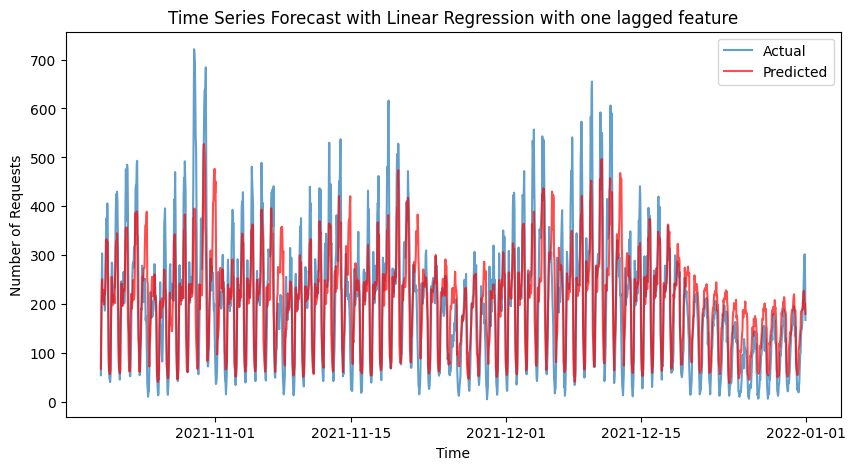

In [171]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test.index, y2_test, label='Actual', alpha=0.7)
plt.plot(y2_test.index, y2_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with Linear Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [172]:
mae_linear2 = mean_absolute_error(y2_test, y2_pred)
mse_linear2 = mean_squared_error(y2_test, y2_pred)
rmse_linear2 = mse_linear2 ** 0.5
r2 = r2_score(y2_test, y2_pred)
print(f'Linear Regression (with one lagged feature) MAE: {mae_linear2}, RMSE: {rmse_linear2}, R2: {r2}')

Linear Regression (with one lagged feature) MAE: 55.53937379708698, RMSE: 79.13452591770071, R2: 0.6238428554163222


As expected, linear model with only one lagged feature has a worse performance, but it could be easier to operationalize this model. We also can try to include more lagged features (like, number of requests n hours ago).

# XGBoost Regression
I'll be using the same data as for Linear regression

In [177]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [178]:
y3_pred = model_xgb.predict(X2_test)

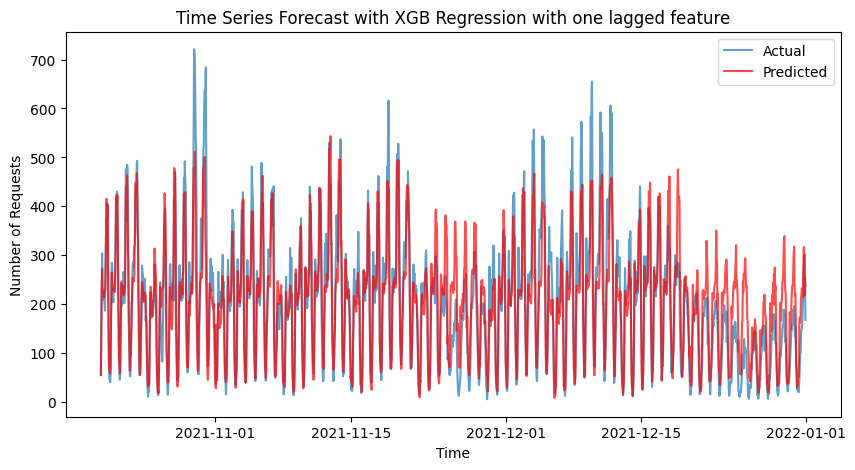

In [179]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y2_test.index, y2_test, label='Actual', alpha=0.7)
plt.plot(y2_test.index, y3_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Time Series Forecast with XGB Regression with one lagged feature')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.show()

In [180]:
mae_xgb = mean_absolute_error(y2_test, y3_pred)
mse_xgb = mean_squared_error(y2_test, y3_pred)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y2_test, y3_pred)
print(f'Linear Regression (with one lagged feature) MAE: {mae_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}')

Linear Regression (with one lagged feature) MAE: 41.66356404331253, RMSE: 59.15309927590065, R2: 0.7898195385932922


XGB model with one lagged feature (previous day trip requests) produced a better R2 score than linear regression with one lagged feature.